In [ ]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!cp /gdrive/MyDrive/ColabNotebooks/img.zip .

In [ ]:
!unzip img.zip

In [ ]:
!du -h -s img/

941M	img/


In [ ]:
from transformers import ViTModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob
from datasets import Dataset, Image
import torchvision.transforms as T

In [ ]:
model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

In [ ]:
imgs = glob.glob("img/**/*.jpg",recursive=True)

In [ ]:
ds = Dataset.from_dict({"image":imgs}).cast_column("image", Image())
ds = ds.shuffle()

In [ ]:
ds = ds.train_test_split(0.01)

In [ ]:
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
transformation_chain = T.Compose([T.ToTensor(), T.Resize((224,224))])

In [ ]:
def extract_embeddings(model: torch.nn.Module):
    device = model.device

    def pp(batch):
        images = batch["image"]
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0]
        return {"embeddings": embeddings}

    return pp

In [ ]:
batch_size = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))

In [ ]:
train_ds_emb = train_ds.map(extract_fn, batched=True, batch_size=batch_size, remove_columns=["image"])
train_ds_emb.set_format("pt",columns=["embeddings"], output_all_columns=True)

Map:   0%|          | 0/52184 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
test_ds_emb = test_ds.map(extract_fn, batched=True, batch_size=batch_size, remove_columns=["image"])
test_ds_emb.set_format("pt",columns=["embeddings"], output_all_columns=True)

Map:   0%|          | 0/528 [00:00<?, ? examples/s]

In [ ]:
def compute_scores(query):
    scores = torch.nn.functional.cosine_similarity(query, train_ds_emb['embeddings'])
    return scores

In [ ]:
def generate_similar_images():
    query_idx = np.random.randint(len(test_ds))
    query_img = test_ds[query_idx]["image"]
    query_emb = test_ds_emb[query_idx]["embeddings"]
    sim_scores = compute_scores(query_emb)
    val = sim_scores.argmax().item()
    return query_img, train_ds[val]["image"]

In [ ]:
query_imgs, sim_imgs = [], []
for _ in range(5):
    x, y = generate_similar_images()
    query_imgs.append(x)
    sim_imgs.append(y)

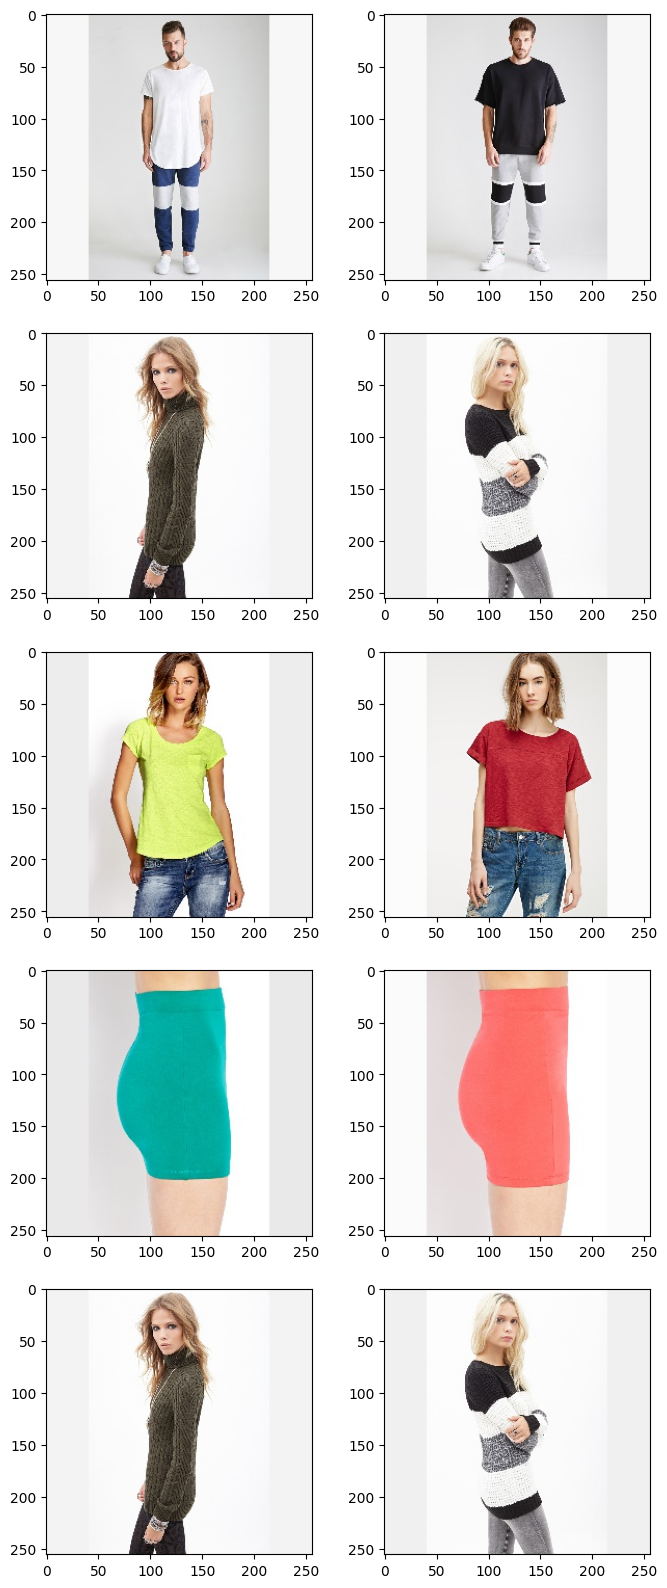

In [ ]:
rows = 5
cols = 2

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8,20))

for i in range(rows):
    axes[i,0].imshow(query_imgs[i])
    axes[i,1].imshow(sim_imgs[i])